# 0.0 - Imports

In [563]:
import warnings

import numpy                    as np
import pandas                   as pd
import seaborn                  as sns
import matplotlib.pyplot        as plt

from IPython.display            import HTML
from datetime                   import datetime
from sklearn.impute             import SimpleImputer
from sklearn.preprocessing      import MinMaxScaler
from tensorflow.keras.models    import Sequential
from tensorflow.keras.layers    import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics            import mean_squared_error, mean_absolute_error
from pandas.plotting            import register_matplotlib_converters
from statsmodels.tsa.seasonal   import seasonal_decompose

# 0.1 - Helper Functions

In [564]:
display(HTML("<style>.container { width:100% !important; }</style>"))

display(HTML("""
<style>
.output {
    display: block;
    width: 100% !important;
    max-height: 1000px !important;
    overflow-y: auto;
}
.output_area {
    width: 100% !important;
    max-height: 1000px !important;
}
</style>
"""))


warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

def create_features(df):
    df = df.copy()    
    df['hour'] = df['Data_Hora'].dt.hour.astype('int64')
    df['dayofweek'] = df['Data_Hora'].dt.dayofweek.astype('int64')
    df['quarter'] = df['Data_Hora'].dt.quarter.astype('int64')
    df['month'] = df['Data_Hora'].dt.month.astype('int64')
    df['year'] = df['Data_Hora'].dt.year.astype('int64')
    df['dayofyear'] = df['Data_Hora'].dt.dayofyear.astype('int64')
    df['dayofmonth'] = df['Data_Hora'].dt.day.astype('int64')
    df['weekofyear'] = df['Data_Hora'].dt.isocalendar().week.astype('int64')

    df['season'] = 'Winter'  # Default to Winter
    df.loc[(df['Data_Hora'] >= df.apply(lambda row: pd.Timestamp(year=row['year'], month=3, day=20), axis=1)) & (df['Data_Hora'] < df.apply(lambda row: pd.Timestamp(year=row['year'], month=6, day=21), axis=1)), 'season'] = 'Spring'
    df.loc[(df['Data_Hora'] >= df.apply(lambda row: pd.Timestamp(year=row['year'], month=6, day=21), axis=1)) & (df['Data_Hora'] < df.apply(lambda row: pd.Timestamp(year=row['year'], month=9, day=23), axis=1)), 'season'] = 'Summer'
    df.loc[(df['Data_Hora'] >= df.apply(lambda row: pd.Timestamp(year=row['year'], month=9, day=23), axis=1)) & (df['Data_Hora'] < df.apply(lambda row: pd.Timestamp(year=row['year'], month=12, day=22), axis=1)), 'season'] = 'Fall'
    df.loc[(df['Data_Hora'] >= df.apply(lambda row: pd.Timestamp(year=row['year'], month=12, day=22), axis=1)) | (df['Data_Hora'] < df.apply(lambda row: pd.Timestamp(year=row['year'], month=3, day=20), axis=1)), 'season'] = 'Winter'
    
    season_map = {'Winter': 4, 'Spring': 1, 'Summer': 2, 'Fall': 3}
    df['season'] = df['season'].map(season_map).astype('int64')
    
    return df

def add_lags(df):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    
    df['tem_lag_1'] = df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].shift(364)
    df['tem_lag_2'] = df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].shift(728)
    df['tem_lag_3'] = df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].shift(1092)

    df = df.reset_index()
    df.drop('index', axis=1, inplace=True)
    
    return df

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 0.1 - Data

In [565]:
dfs = []

for i in range(2002, 2019):
    file = rf"C:\Users\gfurt\Ciência de dados\Séries temporais\inmet_prophet\Dados\INMET_SE_RJ_A601_ECOLOGIA AGRICOLA_01-01-{i}_A_31-12-{i}.csv"
    df = pd.read_csv(file, encoding='ISO-8859-1', delimiter=';', skiprows=8)
    dfs.append(df)
    
df_raw_1 = pd.concat(dfs, ignore_index=True)

In [566]:
cols = df_raw_1.columns
dfs = []

for i in range(2019, 2024):
    file = rf"C:\Users\gfurt\Ciência de dados\Séries temporais\inmet_prophet\Dados\INMET_SE_RJ_A601_SEROPEDICA-ECOLOGIA AGRICOLA_01-01-{i}_A_31-12-{i}.csv"
    df = pd.read_csv(file, encoding='ISO-8859-1', delimiter=';', skiprows=9,
                     names=cols)
    dfs.append(df)
    
df_raw_2 = pd.concat(dfs, ignore_index=True)

In [567]:
df_raw_2['HORA (UTC)'] = df_raw_2['HORA (UTC)'].str[:4]
df_raw_2['HORA (UTC)'] = df_raw_2['HORA (UTC)'].apply(lambda x: datetime.strptime(x, '%H%M').strftime('%H:%M'))

In [568]:
df_raw_1['DATA (YYYY-MM-DD)'] = pd.to_datetime(df_raw_1['DATA (YYYY-MM-DD)'])
df_raw_2['DATA (YYYY-MM-DD)'] = pd.to_datetime(df_raw_2['DATA (YYYY-MM-DD)'])

In [569]:
df_raw = pd.concat([df_raw_1, df_raw_2], ignore_index=True)

# 1.0 - Data description

In [570]:
df1 = df_raw.copy()

## 1.1 - Data dimensions

In [571]:
df1.shape

(192840, 20)

## 1.2 - Data Type

In [572]:
df1.dtypes

DATA (YYYY-MM-DD)                                        datetime64[ns]
HORA (UTC)                                                       object
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                                 object
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)            object
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)                  object
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)                 object
RADIACAO GLOBAL (KJ/m²)                                          object
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)                     object
TEMPERATURA DO PONTO DE ORVALHO (°C)                             object
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)                       object
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)                       object
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)                 object
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)                 object
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                        

In [573]:
columns = df1.columns[2:-1]

for i in columns:
    df1[i] = df1[i].astype(str)
    df1[i] = df1[i].str.replace(',', '.')
    df1[i] = df1[i].astype(float)

In [574]:
df1.dtypes

DATA (YYYY-MM-DD)                                        datetime64[ns]
HORA (UTC)                                                       object
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                                float64
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)           float64
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)                 float64
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)                float64
RADIACAO GLOBAL (KJ/m²)                                         float64
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)                    float64
TEMPERATURA DO PONTO DE ORVALHO (°C)                            float64
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)                      float64
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)                      float64
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)                float64
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)                float64
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                        

## 1.3 - Missing Values

In [575]:
total_values = df1.shape[0]
missing_values = df1.isnull().sum()
percent_missing = (missing_values / total_values) * 100

missing_data_table = pd.DataFrame({
    'Total': total_values,
    'Missing': missing_values,
    'Percent Missing': percent_missing
})

missing_data_table['Percent Missing'] = missing_data_table['Percent Missing'].map(lambda x: f'{x:.2f}%')
missing_data_table

,Total,Missing,Percent Missing
DATA (YYYY-MM-DD),192840,0,0.00%
HORA (UTC),192840,0,0.00%
"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",192840,2296,1.19%
"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",192840,2196,1.14%
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),192840,2201,1.14%
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),192840,2201,1.14%
RADIACAO GLOBAL (KJ/m²),192840,20770,10.77%
"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",192840,962,0.50%
TEMPERATURA DO PONTO DE ORVALHO (°C),192840,962,0.50%
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),192840,969,0.50%


## 1.4 - Descriptive statistics

In [576]:
df1.describe()

,DATA (YYYY-MM-DD),"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19
count,192840,190544.000000,190644.000000,190639.000000,190639.000000,172070.000000,191878.000000,191878.000000,191871.000000,191872.000000,191872.000000,191871.000000,191872.000000,191872.000000,191878.000000,191881.000000,191873.000000,191881.000000,0.0
mean,2012-12-31 00:00:00,-546.106078,513.676597,508.019335,507.527419,-2646.579677,-426.784848,-436.743821,-429.414992,-430.425210,-439.893117,-440.796756,-380.795619,-386.381004,-379.924608,-652.901163,-508.482934,-500.918342,NaN
min,2002-01-01 00:00:00,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,NaN
25%,2007-07-02 00:00:00,0.000000,1008.200000,1008.400000,1007.900000,-9999.000000,20.200000,16.600000,20.600000,19.700000,17.100000,16.100000,66.000000,58.000000,62.000000,31.000000,2.000000,0.600000,NaN
50%,2012-12-31 00:00:00,0.000000,1011.400000,1011.700000,1011.200000,62.200000,23.100000,19.200000,23.600000,22.600000,19.600000,18.700000,84.000000,76.000000,80.000000,195.000000,3.800000,1.600000,NaN
75%,2018-07-02 00:00:00,0.000000,1015.100000,1015.400000,1014.900000,1246.800000,26.300000,21.300000,27.100000,25.600000,21.700000,20.900000,93.000000,90.000000,92.000000,299.000000,6.200000,2.800000,NaN
max,2023-12-31 00:00:00,66.200000,1029.700000,1029.700000,1029.400000,6300.200000,42.400000,27.200000,42.600000,41.500000,27.600000,26.800000,100.000000,100.000000,100.000000,360.000000,39.900000,13.700000,NaN
std,NaN,2272.330083,2288.979966,2301.906344,2301.798652,5294.042664,2076.675194,2087.574292,2083.820176,2083.342623,2095.547655,2095.355405,2105.421488,2105.094332,2097.399881,2807.378519,2206.432142,2185.457001,NaN


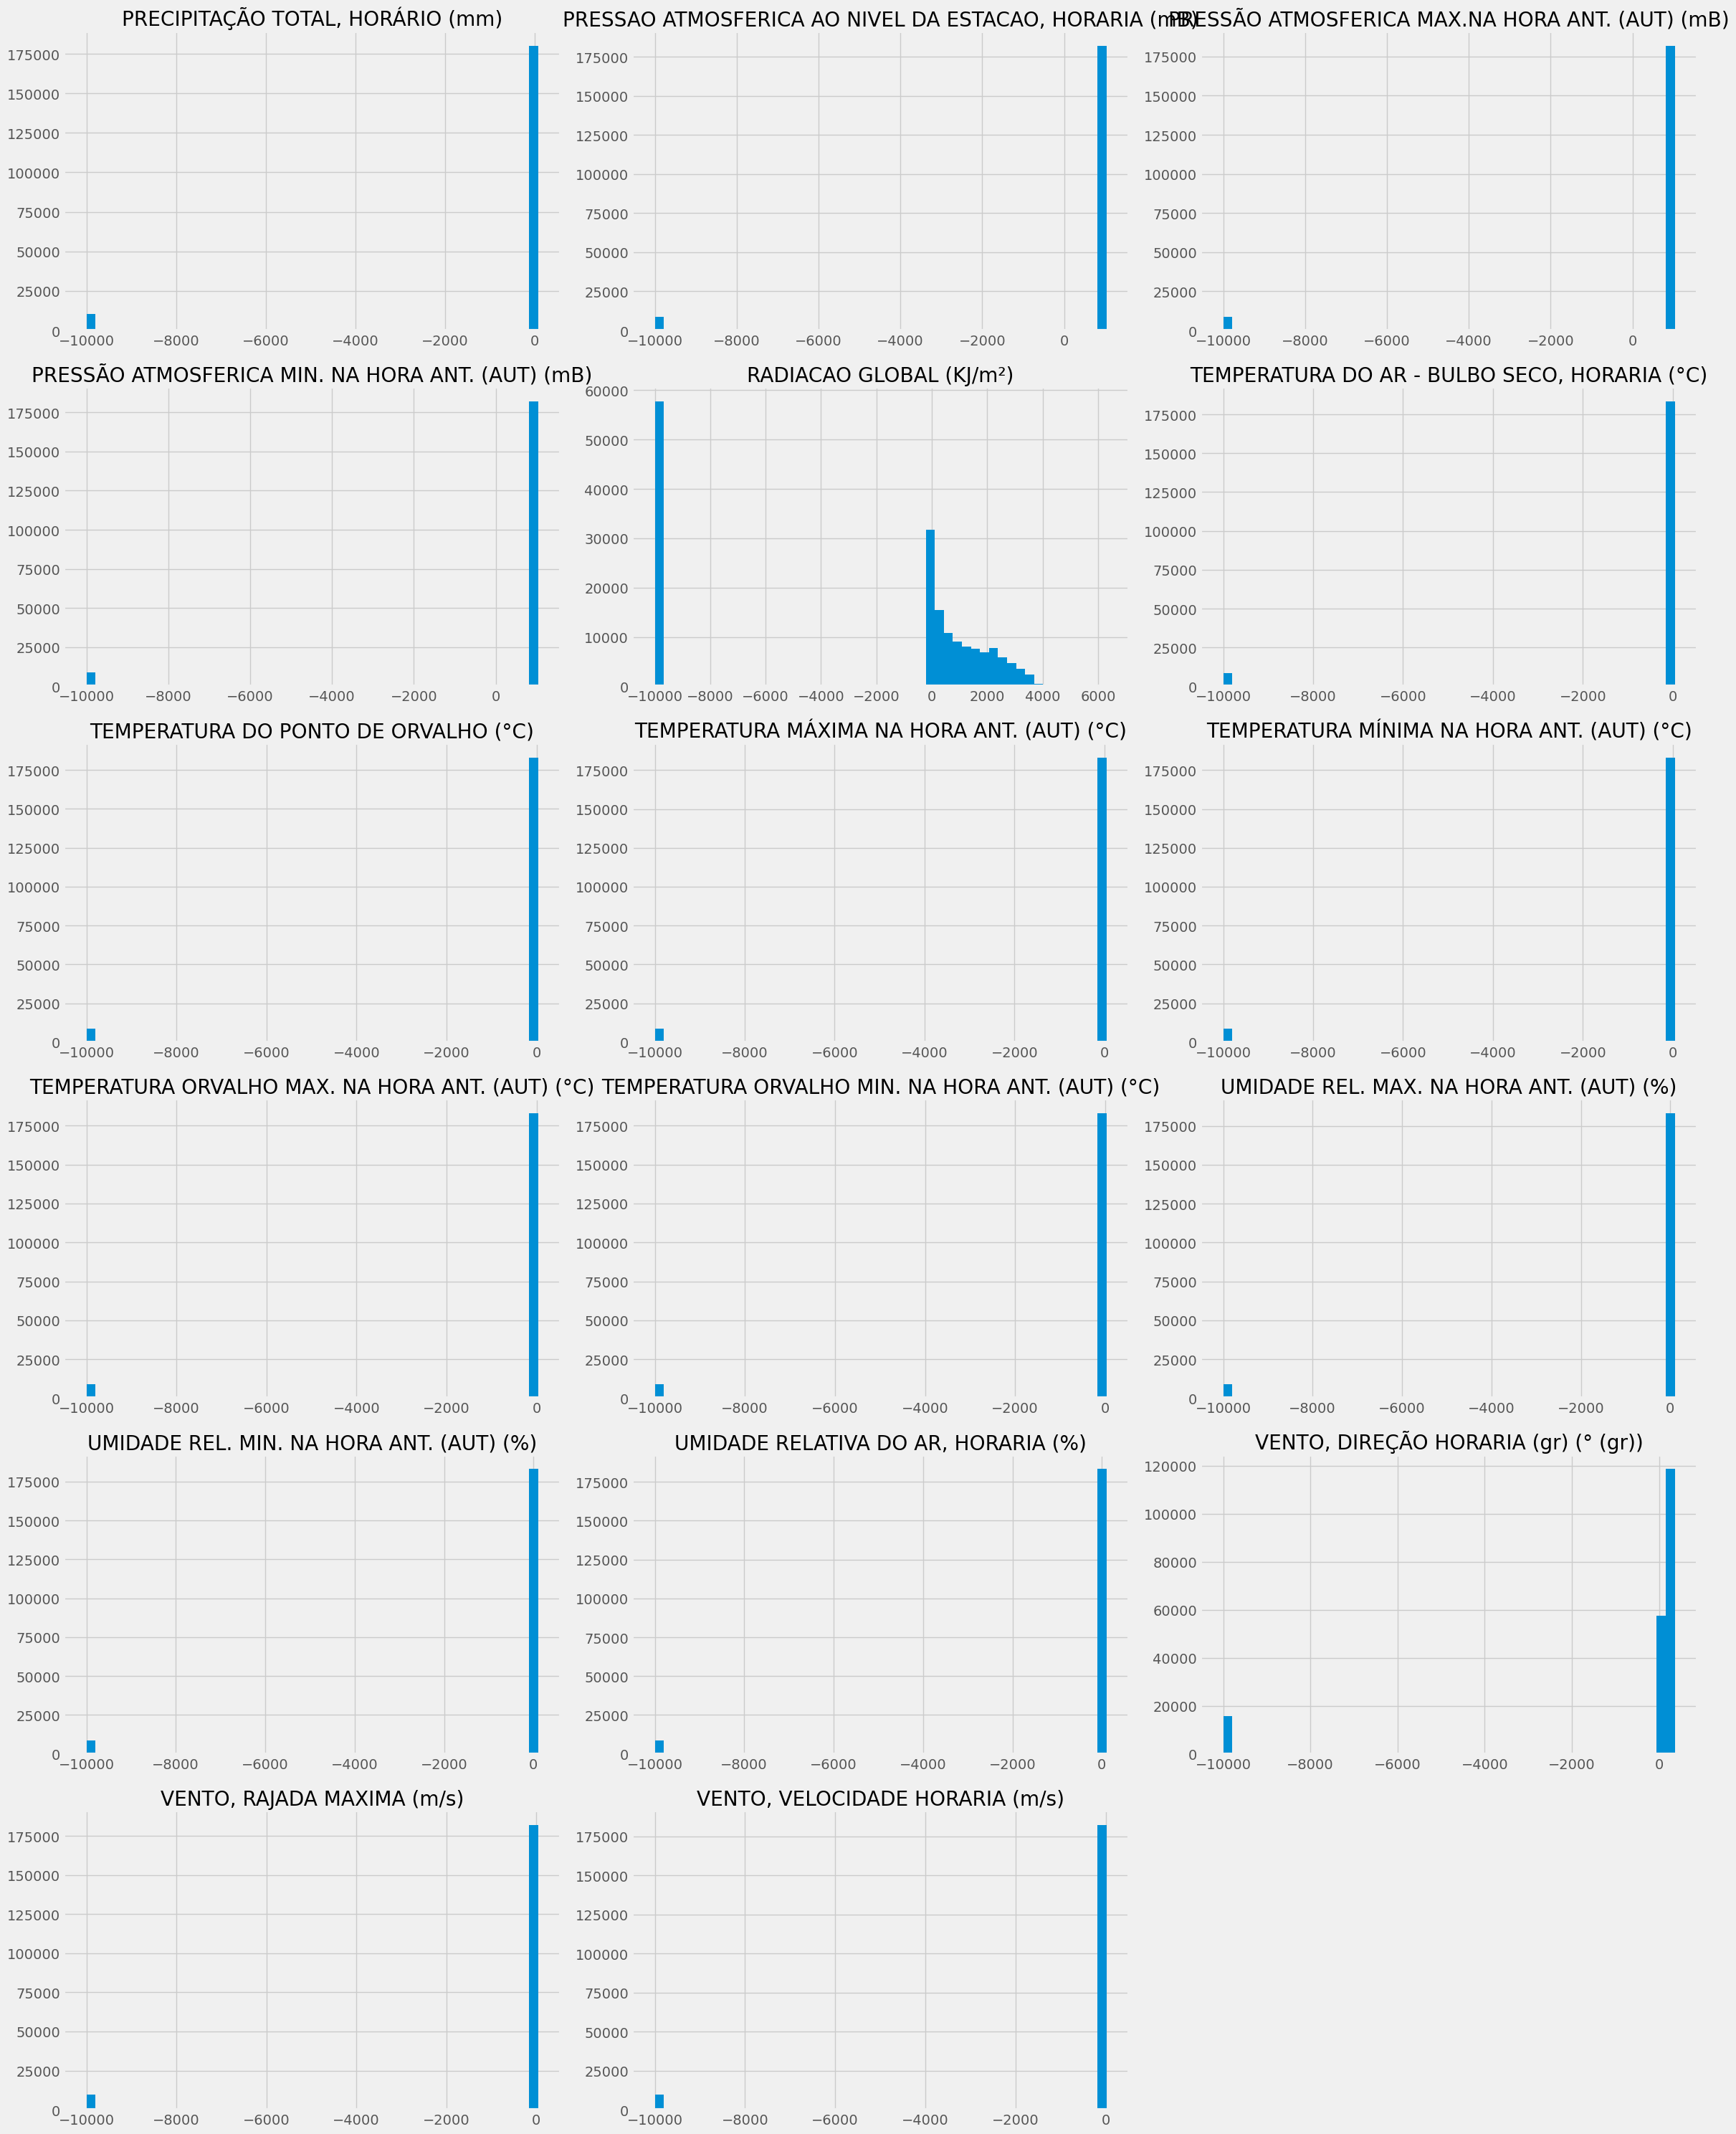

In [577]:
df_aux = df1.iloc[:,2:-1].copy()

num_columns = len(df_aux.columns)
num_rows = (num_columns + 3) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(24, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(df_aux.columns):
    df_aux[col].hist(bins=50, ax=axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# 2.0 - Feature engineering

In [578]:
df2 = df1.copy()

In [579]:
df2['HORA (UTC)'] = pd.to_timedelta(df2['HORA (UTC)'] + ':00')
df2['Data_Hora'] = df2['DATA (YYYY-MM-DD)'] + df2['HORA (UTC)']

df2['Data_Hora'] = pd.to_datetime(df2['Data_Hora'])

In [580]:
# creating columns 'date, hour, dayofweek, quarter, month, year, dayofyear, dayofmonth, weekofyear, season'

df2 = create_features(df2)

# 3.0 - Data Cleaning

In [581]:
df3 = df2.copy()

## 3.1 - Replace -9999 values for nan

In [582]:
df3 = df3.replace(-9999, np.nan)

## 3.2 - Removing columns

In [583]:
columns_ordered = [
    'Data_Hora', 'hour', 'dayofweek', 'quarter', 'month', 'year',
    'dayofyear', 'dayofmonth', 'weekofyear', 'season',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'
]

# Reindexar o DataFrame com a ordem desejada das colunas
df3 = df3.reindex(columns=columns_ordered)

## 3.4 - Missing values

In [584]:
imputer = SimpleImputer(strategy='mean')

df3['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'] = imputer.fit_transform(df3[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']])

df3.isnull().sum()

Data_Hora                                       0
hour                                            0
dayofweek                                       0
quarter                                         0
month                                           0
year                                            0
dayofyear                                       0
dayofmonth                                      0
weekofyear                                      0
season                                          0
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)    0
dtype: int64

# 4.0 - Exploratory Data Analysis

In [585]:
df4 = df3.copy()

# 5.0 - Data Preparation

In [586]:
df5 = df4.copy()

In [587]:
df5 = df5.set_index('Data_Hora')

In [588]:
mms = MinMaxScaler()

df5['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'] = mms.fit_transform(df5[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']])

# 6.0 - Feature Selection

In [589]:
df6 = df5.copy()

In [590]:
df6 = df6[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']].copy()

In [591]:
train = df6.loc[df6.index < '2023-01-01']
test = df6.loc[df6.index >= '2023-01-01']

In [592]:
def create_sequences(data, n_input):
    sequences = []
    labels = []
    for i in range(len(data) - 2 * n_input):
        seq = data[i:i + n_input]
        label = data[i + 2 * n_input]  # Prever 24 horas após o final da sequência
        sequences.append(seq)
        labels.append(label)
    sequences = np.array(sequences)
    labels = np.array(labels)
    return sequences, labels

In [593]:
n_input = 24
X_train, y_train = create_sequences(train['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].values, n_input)
X_test, y_test = create_sequences(test['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].values, n_input)

In [594]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 7.0 - Machine Learning

In [595]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_input, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse') #model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [596]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [597]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/50


4601/4601 ━━━━━━━━━━━━━━━━━━━━ 60s 12ms/step - loss: 0.0154 - val_loss: 0.0064
Epoch 2/50
4601/4601 ━━━━━━━━━━━━━━━━━━━━ 60s 13ms/step - loss: 0.0069 - val_loss: 0.0061
Epoch 3/50
4601/4601 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 4/50
4601/4601 ━━━━━━━━━━━━━━━━━━━━ 72s 16ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 5/50
4601/4601 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 6/50
4601/4601 ━━━━━━━━━━━━━━━━━━━━ 61s 13ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 7/50
4601/4601 ━━━━━━━━━━━━━━━━━━━━ 61s 13ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 8/50
4601/4601 ━━━━━━━━━━━━━━━━━━━━ 61s 13ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 9/50
4601/4601 ━━━━━━━━━━━━━━━━━━━━ 64s 14ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 10/50
4601/4601 ━━━━━━━━━━━━━━━━━━━━ 65s 14ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 11/50
4601/4601 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 12/50
4601/46

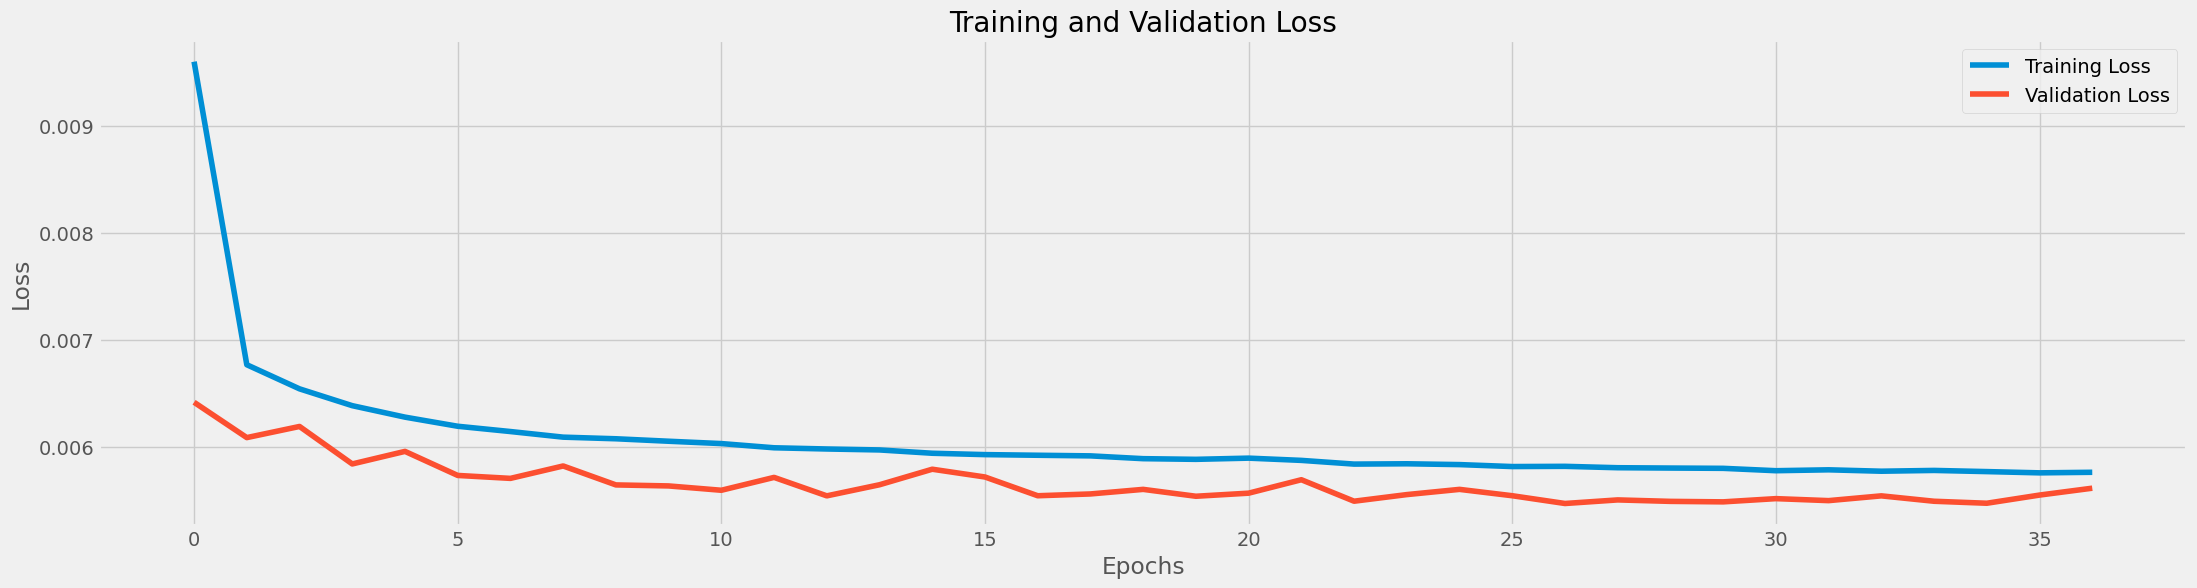

In [598]:
plt.figure(figsize=(24, 6)) 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 8.0 - Model Evaluation

In [599]:
predictions = model.predict(X_test)

predictions_rescaled = mms.inverse_transform(predictions)
y_test_rescaled = mms.inverse_transform(y_test.reshape(-1, 1))

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


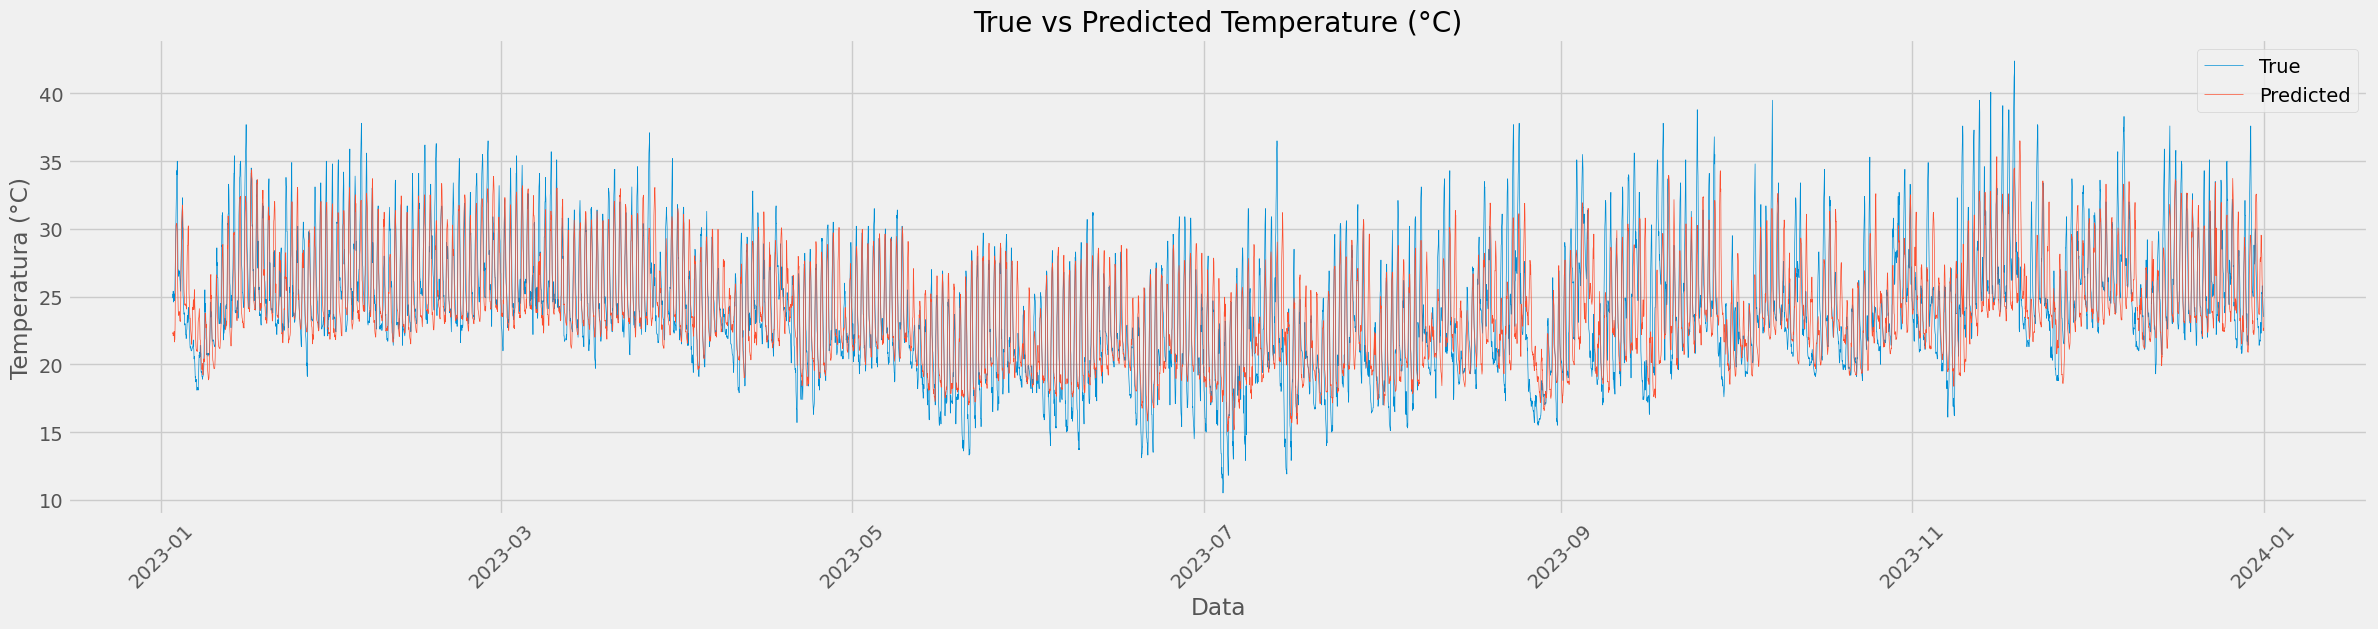

In [600]:
dates = df6.index[-len(y_test_rescaled):]

plt.figure(figsize=(24, 6))

plt.plot(dates, y_test_rescaled, label='True', linewidth=0.5)
plt.plot(dates, predictions_rescaled, label='Predicted', linewidth=0.5)

plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.title('True vs Predicted Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

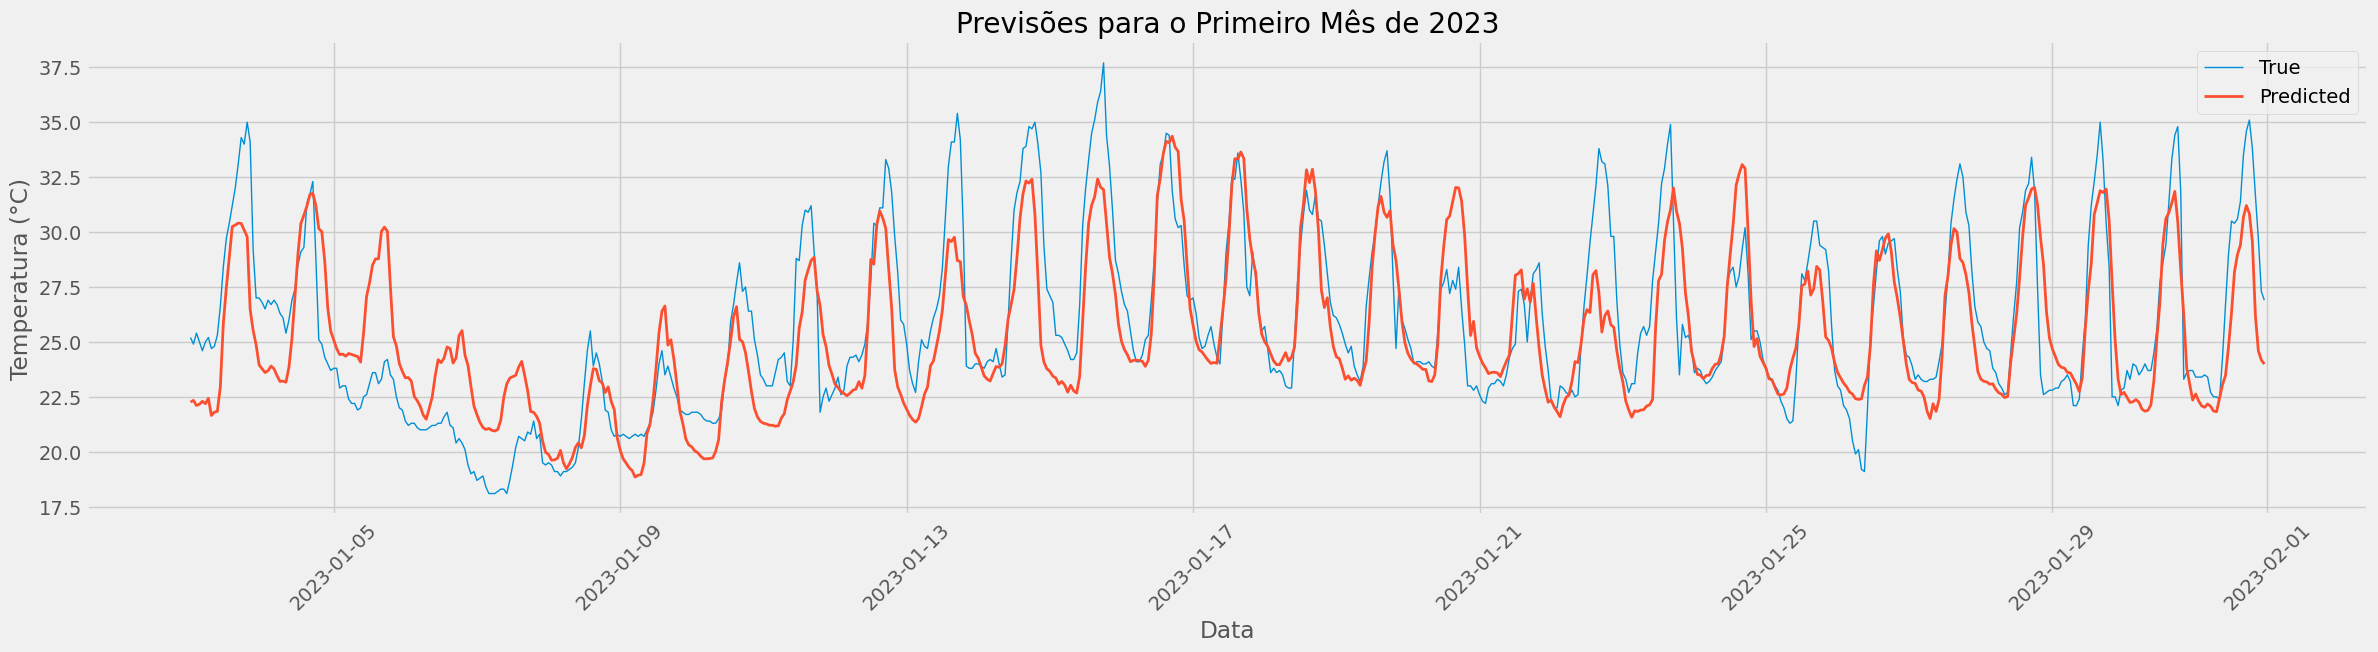

In [601]:
mask = (dates >= '2023-01-01') & (dates < '2023-02-01')
dates_filtered = dates[mask]
y_test_filtered = y_test_rescaled[mask]
predictions_filtered = predictions_rescaled[mask]

plt.figure(figsize=(24, 6)) 

plt.plot(dates_filtered, y_test_filtered, label='True', linewidth=1)
plt.plot(dates_filtered, predictions_filtered, label='Predicted', linewidth=2)

plt.xlabel('Data') 
plt.ylabel('Temperatura (°C)') 
plt.title('Previsões para o Primeiro Mês de 2023') 
plt.legend() 
plt.tight_layout()  
plt.xticks(rotation=45) 

plt.show()


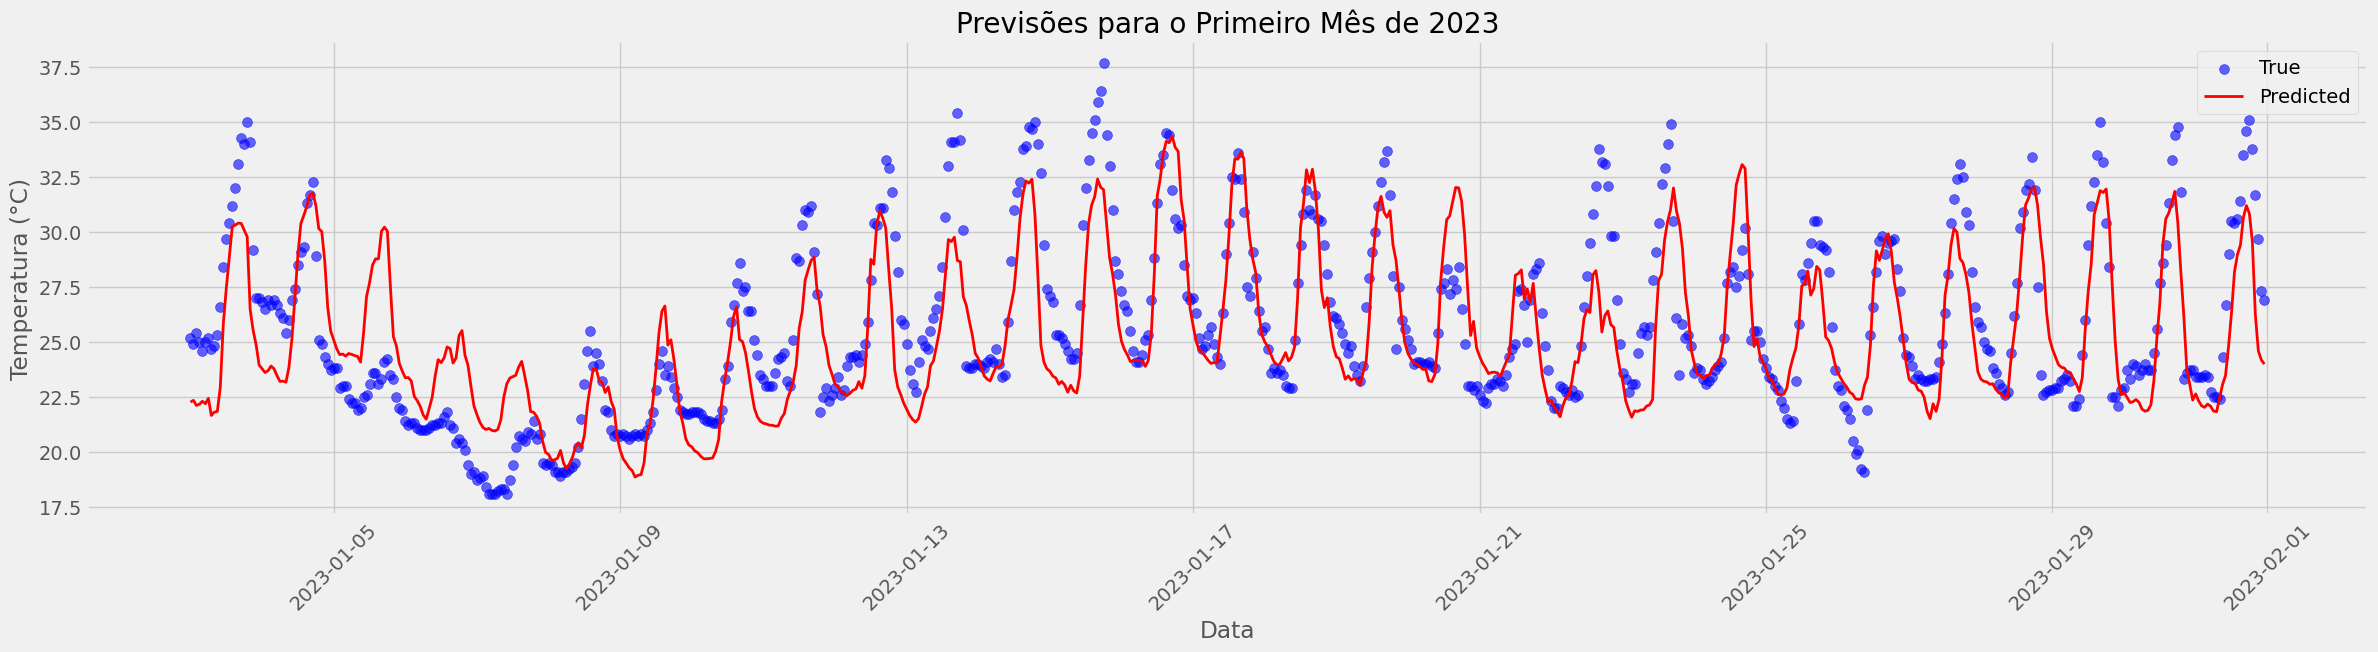

In [602]:
mask = (dates >= '2023-01-01') & (dates < '2023-02-01')
dates_filtered = dates[mask]
y_test_filtered = y_test_rescaled[mask]
predictions_filtered = predictions_rescaled[mask]

plt.figure(figsize=(24, 6))  

plt.scatter(dates_filtered, y_test_filtered, label='True', marker='o', s=50, color='blue', alpha=0.6)
plt.plot(dates_filtered, predictions_filtered, label='Predicted', linewidth=2, color='red')

plt.xlabel('Data')  
plt.ylabel('Temperatura (°C)') 
plt.title('Previsões para o Primeiro Mês de 2023') 
plt.legend()  
plt.tight_layout() 
plt.xticks(rotation=45)  

plt.show()


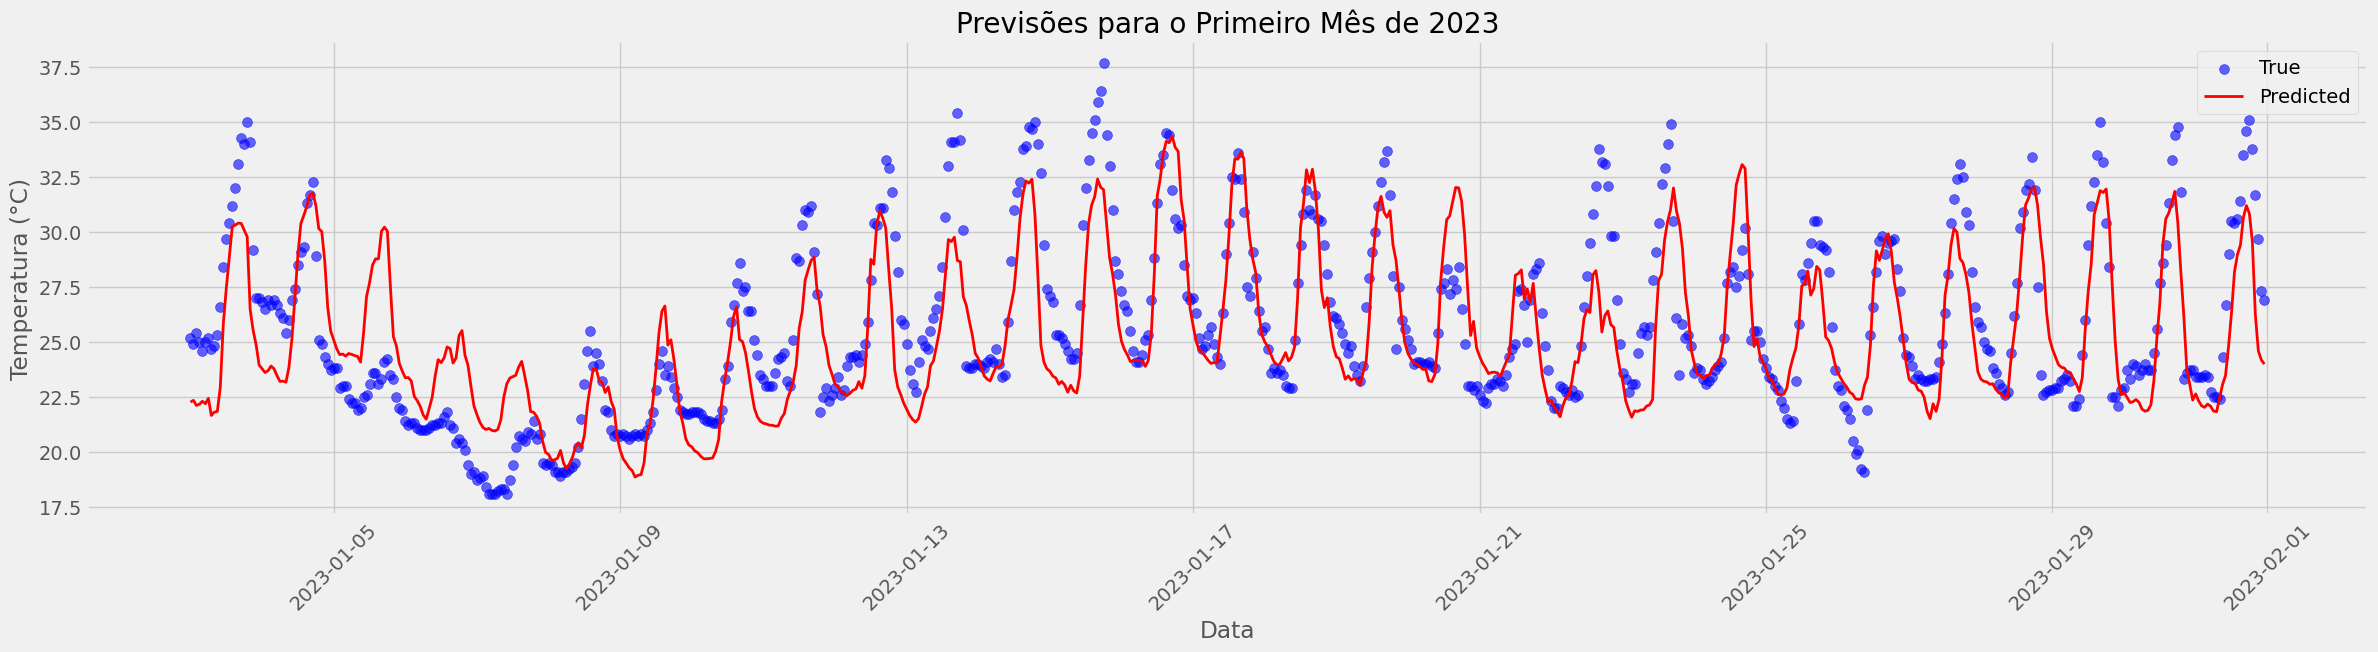

In [603]:
mask = (dates >= '2023-01-01') & (dates < '2023-02-01')
dates_filtered = dates[mask]
y_test_filtered = y_test_rescaled[mask]
predictions_filtered = predictions_rescaled[mask]

plt.figure(figsize=(24, 6))  

plt.scatter(dates_filtered, y_test_filtered, label='True', marker='o', s=50, color='blue', alpha=0.6)
plt.plot(dates_filtered, predictions_filtered, label='Predicted', linewidth=2, color='red')

plt.xlabel('Data')  
plt.ylabel('Temperatura (°C)')  
plt.title('Previsões para o Primeiro Mês de 2023')  
plt.legend()  
plt.tight_layout() 
plt.xticks(rotation=45)  

plt.show()


In [604]:
test_dates = test.index[-len(y_test_rescaled):]
test_values = y_test_rescaled.flatten()

df_test = pd.DataFrame({'Data': test_dates, 'Valor_Real': test_values})
df_test['Prediction'] = predictions_rescaled.flatten()
df_test

,Data,Valor_Real,Prediction
0,2023-01-03 00:00:00,25.2,22.264328
1,2023-01-03 01:00:00,24.9,22.339718
2,2023-01-03 02:00:00,25.4,22.108932
3,2023-01-03 03:00:00,25.0,22.163450
4,2023-01-03 04:00:00,24.6,22.299852
...,...,...,...
8707,2023-12-31 19:00:00,25.2,24.957512
8708,2023-12-31 20:00:00,24.8,24.161114
8709,2023-12-31 21:00:00,24.3,23.340555
8710,2023-12-31 22:00:00,23.9,22.486536


In [605]:
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mape = np.mean(np.abs((y_test_rescaled - predictions_rescaled) / y_test_rescaled)) * 100

results_df = pd.DataFrame({
    'MSE': [mse],
    'RMSE': [rmse],
    'MAE': [mae],
    'MAPE': [mape]
}, index=['Final Model'])

results_df

,MSE,RMSE,MAE,MAPE
Final Model,7.416623,2.723348,2.017822,8.480519


In [606]:
residuals = y_test_rescaled - predictions_rescaled

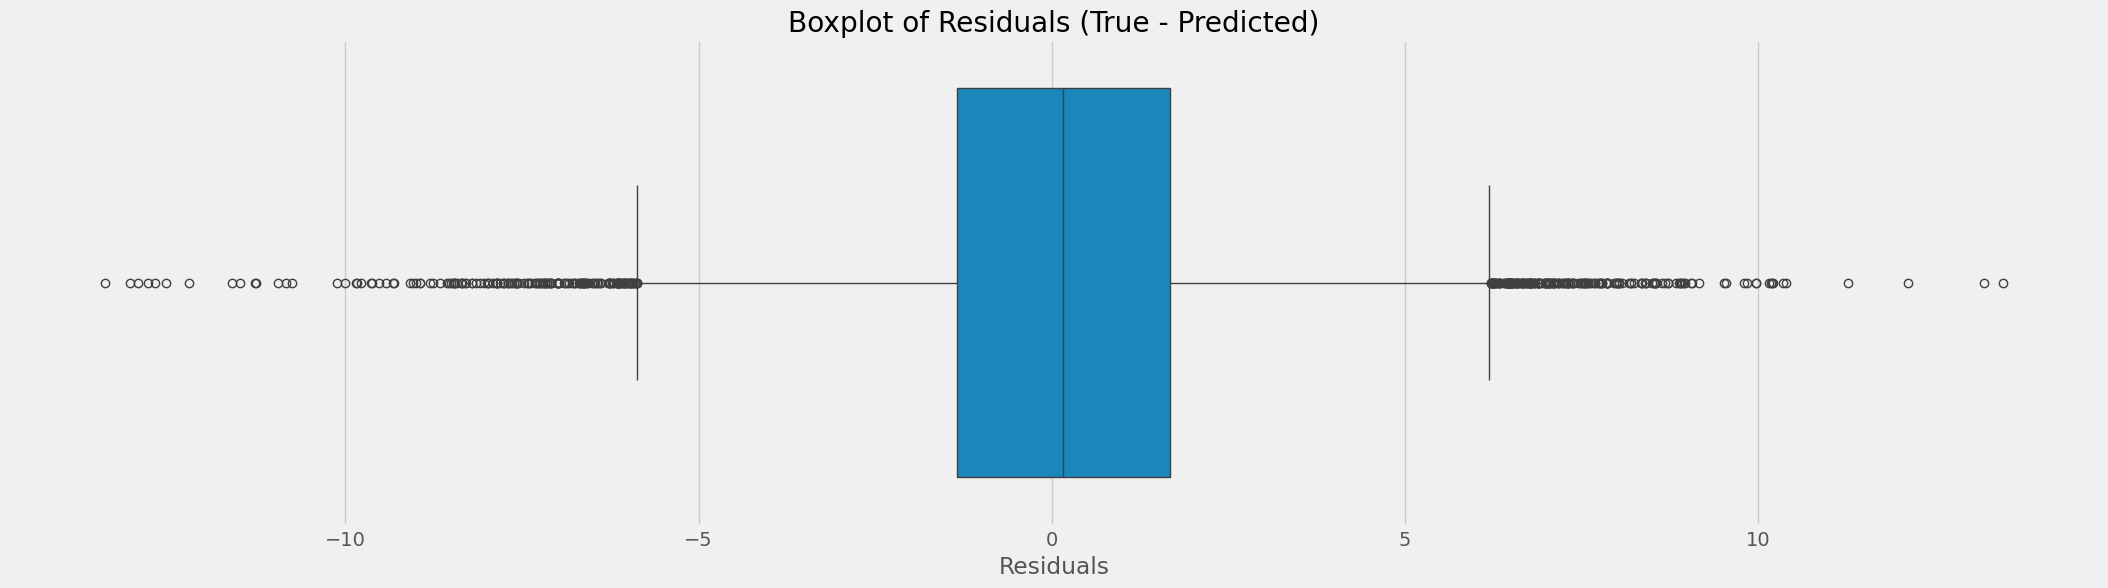

In [607]:
plt.figure(figsize=(24, 6))
sns.boxplot(x=residuals.flatten())  
plt.xlabel('Residuals')
plt.title('Boxplot of Residuals (True - Predicted)')
plt.show()


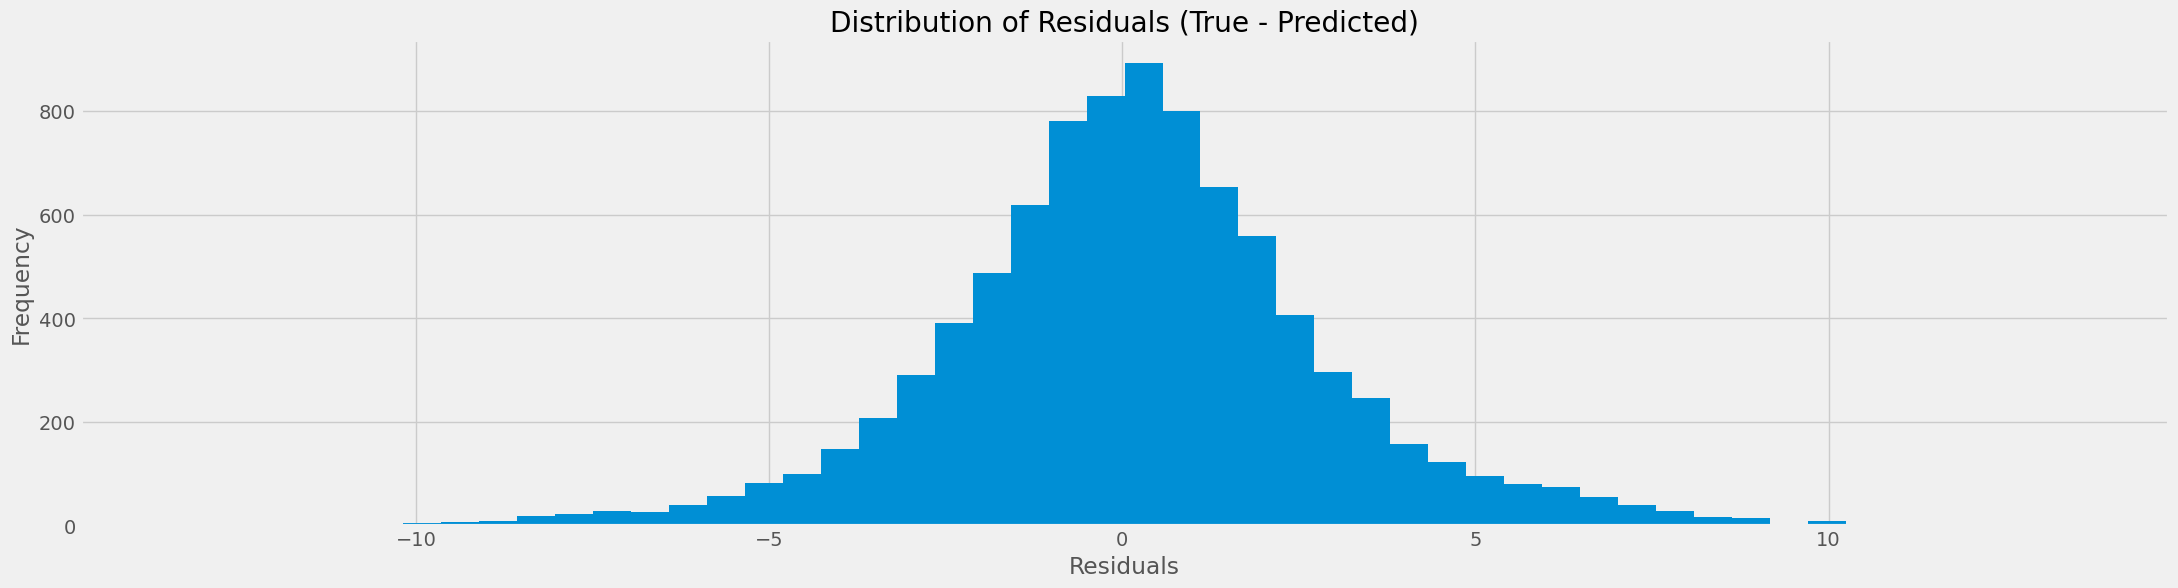

In [608]:
plt.figure(figsize=(24, 6))
residuals = y_test_rescaled - predictions_rescaled
plt.hist(residuals, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (True - Predicted)')
plt.show()

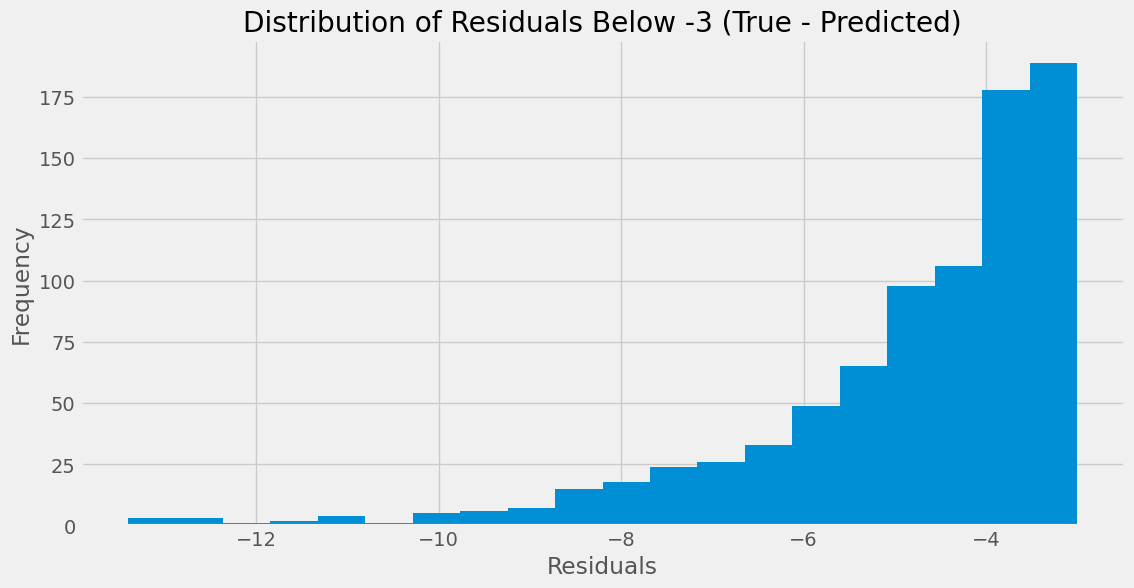

In [609]:
plt.figure(figsize=(12, 6))
residuals_below_minus_3 = residuals[residuals < -3]
plt.hist(residuals_below_minus_3, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals Below -3 (True - Predicted)')
plt.show()


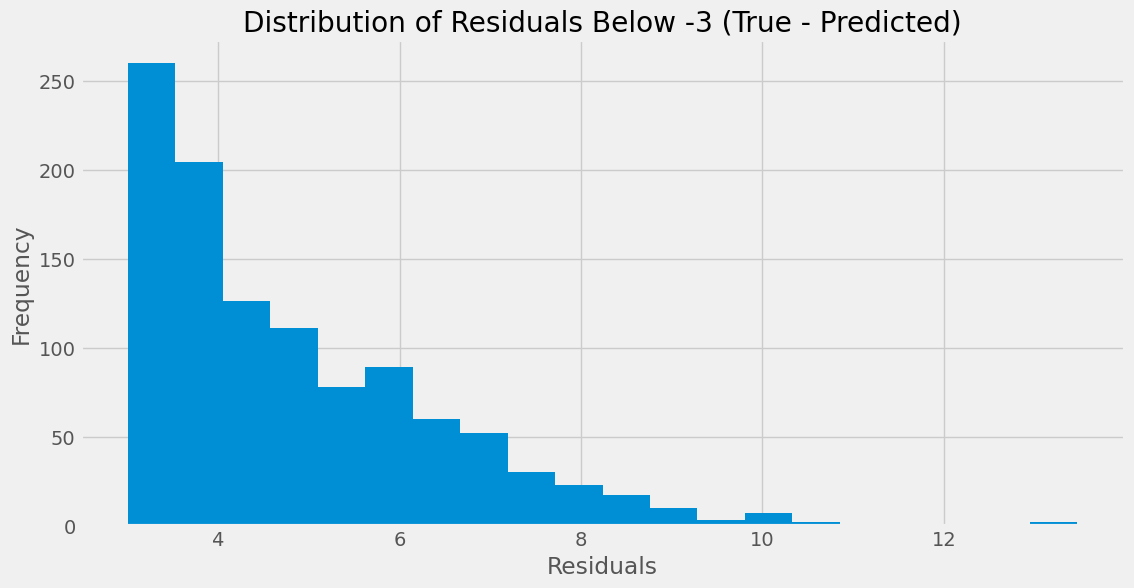

In [610]:
plt.figure(figsize=(12, 6))
residuals_below_minus_3 = residuals[residuals > +3]
plt.hist(residuals_below_minus_3, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals Below -3 (True - Predicted)')
plt.show()
